# Transfer learning with TensorFlow part 3: Scaling up

we've ween the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food)

our goal is to beat the original Food101 paper with 10% of the training data (leveraging the power of deep learning)

https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

our baseline is to beat 50.76% accuracy across 101 classes

In [2]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Creating Helper function

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2024-05-07 07:54:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-05-07 07:54:51 (12.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves
from helper_functions import unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data
### 10% of data

### Download and preprocess the data

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"


--2024-05-07 07:54:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.207, 64.233.189.207, 142.250.157.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  29.3MB/s    in 57s     

2024-05-07 07:55:54 (27.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pulled_pork_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tuna_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/churros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_toast'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_quesadilla'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/strawberry_shortcake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/red_velvet_cake'.
There are 0

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                shuffle = False) #by default True

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


- 75 * 101 = 7575
- 250 * 101 = 25250

In [8]:
train_data_all_10_percent.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

## Training Big model with Transfer learning on 10% of 101 food classes

To keep our experiments swift, we're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

More specifically, our goal will be to see if we can beat the baseline from original Food101 paper (50.76% accuracy on 101 classes) with 10% of the training data and the following modelling setup:

- A ModelCheckpoint callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
- Data augmentation built right into the model
- A headless (no top layers) EfficientNetB0 architecture from tf.keras.applications as our base model
- A Dense layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
- Categorical crossentropy as the loss function since we're dealing with more than two classes
- The Adam optimizer with the default settings
- Fitting for 5 full passes on the training data while evaluating on 15% of the test data

Start by creating the `Model_checkpoint`

In [9]:
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = 'val_accuracy',
                                                         save_best_only = True)

`Data augmentation layer`

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# new: newer version of Tensorflow (2.10+ )can use the tensorflow.keras.layers api directly for augmentation

data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)

], name = 'data_augmentation')



In [17]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = layers.Input(shape = IMG_SIZE + (3,), name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_2d')(x)
outputs = layers.Dense(len(test_data.class_names), activation = 'softmax', name = 'output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_2d   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                           

In [19]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs= 5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15 * len(test_data)),
                                           callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 159s 619ms/step - loss: 3.3996 - accuracy: 0.2679 - val_loss: 2.3064 - val_accuracy: 0.4772
Epoch 2/5
237/237 [==============================] - 103s 433ms/step - loss: 2.2374 - accuracy: 0.4846 - val_loss: 1.8795 - val_accuracy: 0.5360
Epoch 3/5
237/237 [==============================] - 94s 393ms/step - loss: 1.8519 - accuracy: 0.5620 - val_loss: 1.7169 - val_accuracy: 0.5651
Epoch 4/5
237/237 [==============================] - 83s 350ms/step - loss: 1.6491 - accuracy: 0.6024 - val_loss: 1.6313 - val_accuracy: 0.5657
Epoch 5/5
237/237 [==============================] - 78s 326ms/step - loss: 1.4803 - accuracy: 0.6356 - val_loss: 1.5875 - val_accuracy: 0.5789


In [20]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 57s 71ms/step - loss: 1.5910 - accuracy: 0.5790


[1.5910340547561646, 0.5790495276451111]

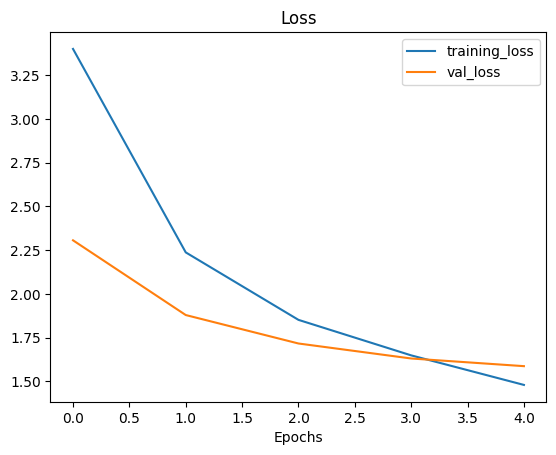

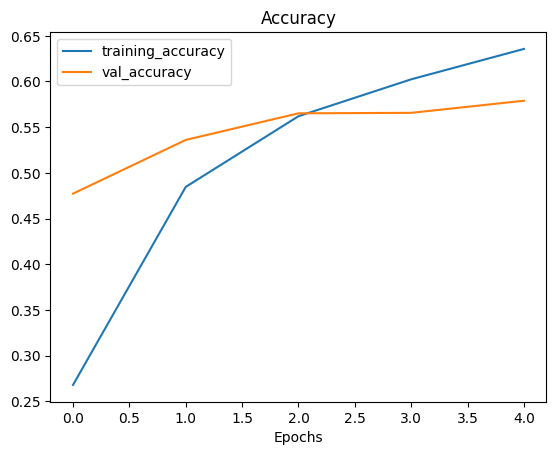

In [21]:
plot_loss_curves(history_all_classes_10_percent)

### `Fine Tuning`

In [22]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False


In [23]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              metrics = ['accuracy'])

In [25]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_2d True
output_layer True


In [26]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [29]:
history_all_classes_10_percent.epoch[-1]

4

In [30]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15 * len(train_data_all_10_percent)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 73s 273ms/step - loss: 1.2551 - accuracy: 0.6725 - val_loss: 1.4934 - val_accuracy: 0.6036
Epoch 6/10
237/237 [==============================] - 59s 245ms/step - loss: 1.1294 - accuracy: 0.6917 - val_loss: 1.4424 - val_accuracy: 0.6196
Epoch 7/10
237/237 [==============================] - 55s 229ms/step - loss: 1.0591 - accuracy: 0.7196 - val_loss: 1.4314 - val_accuracy: 0.6170
Epoch 8/10
237/237 [==============================] - 52s 218ms/step - loss: 0.9929 - accuracy: 0.7304 - val_loss: 1.4956 - val_accuracy: 0.6018
Epoch 9/10
237/237 [==============================] - 52s 219ms/step - loss: 0.9344 - accuracy: 0.7442 - val_loss: 1.4776 - val_accuracy: 0.5991
Epoch 10/10
237/237 [==============================] - 47s 195ms/step - loss: 0.8826 - accuracy: 0.7603 - val_loss: 1.4781 - val_accuracy: 0.6116


In [31]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 61s 76ms/step - loss: 1.4824 - accuracy: 0.6067


[1.4823684692382812, 0.6066534519195557]

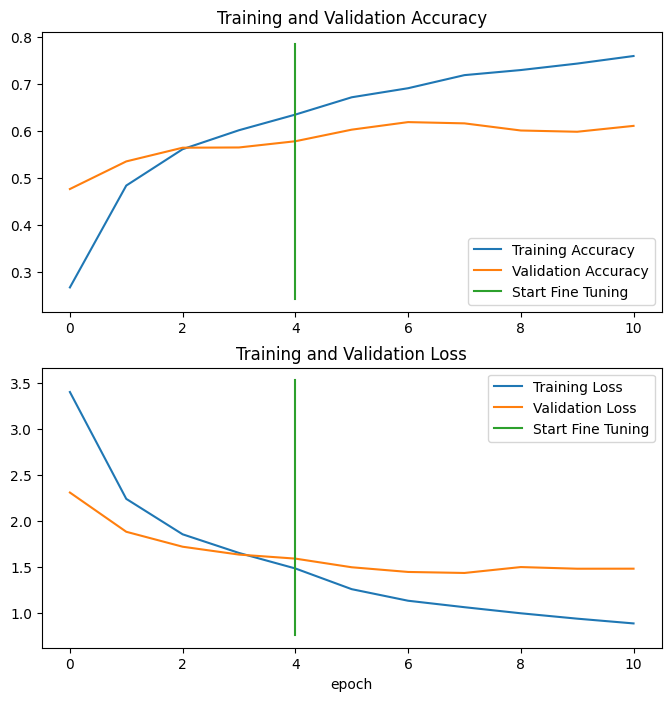

In [32]:
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit.

This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, EfficientNetB0 was trained on ImageNet which contains many real life pictures of food just like our food dataset.

If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

## Saving our trained model

In [33]:
# # Save model to drive so it can be used later
# model.save("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

## Evaluating the performance fo the big dog model aross all different classes

We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.

But metrics schmetrics, let's dive a little deeper into our model's performance and get some visualizations going.

To do so, we'll load in the saved model and use it to make some predictions on the test dataset.

> 🔑 Note: Evaluating a machine learning model is as important as training one. Metrics can be deceiving. You should always visualize your model's performance on unseen data to make sure you aren't being fooled good looking training numbers.

In [11]:


import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

model = tf.keras.models.load_model(saved_model_path.split('.')[0])

--2024-05-07 07:56:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.207, 142.250.157.207, 108.177.97.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  15.0MB/s    in 3.0s    

2024-05-07 07:56:58 (15.0 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [12]:
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

 25/790 [..............................] - ETA: 28:32 - loss: 2.3466 - accuracy: 0.5100

KeyboardInterrupt: 

## Making predictions with our trained model

In [36]:
pred_probs = model.predict(test_data, verbose = 1)

790/790 [==============================] - 67s 81ms/step


In [37]:
pred_probs.shape

(25250, 101)

In [38]:
pred_probs[:10]

array([[8.1351545e-06, 1.6240581e-09, 1.8941725e-03, ..., 3.8599796e-03,
        3.5270955e-06, 8.8520651e-04],
       [1.3027767e-07, 1.5019187e-12, 2.6632784e-13, ..., 1.1721811e-05,
        2.7213440e-10, 5.0984260e-02],
       [4.0237652e-03, 2.0375918e-03, 2.1795688e-04, ..., 2.8678004e-03,
        1.7070750e-04, 2.2029044e-02],
       ...,
       [1.0175811e-07, 2.1526322e-12, 1.7744025e-08, ..., 7.9313111e-08,
        9.3230290e-07, 1.3492695e-07],
       [2.6200179e-03, 5.3573740e-07, 8.0612544e-03, ..., 8.3941168e-06,
        3.6102426e-03, 1.1412666e-07],
       [2.0301464e-08, 4.3735196e-11, 9.9657836e-07, ..., 8.5248106e-13,
        3.1895230e-11, 3.2840777e-08]], dtype=float32)

In [39]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")


Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [8.1351545e-06 1.6240581e-09 1.8941725e-03 4.6286384e-09 3.2532193e-06
 3.8310877e-06 2.4527218e-03 6.5480753e-13 5.7640881e-07 6.4956912e-06
 3.3422194e-03 1.6930427e-09 5.3468120e-01 1.5059652e-04 1.6317979e-02
 5.1629133e-08 2.6127622e-01 4.8818428e-02 6.7550325e-09 4.0496761e-04
 1.5646540e-08 6.0957509e-06 4.8169808e-05 2.5780727e-03 1.9992867e-06
 3.6649366e-05 1.1235236e-06 3.3198884e-07 1.3592492e-05 3.5212743e-06
 2.5506797e-08 8.7539098e-05 9.1123138e-06 7.5360240e-10 1.0282083e-07
 4.8194551e-08 1.7192977e-05 3.7581756e-07 2.9212243e-08 3.5007123e-03
 1.2012085e-06 1.3745718e-08 2.1019002e-04 8.2569146e-10 1.1214099e-11
 3.1708573e-11 1.7339471e-03 5.2387009e-07 9.1902430e-11 2.8936553e-03
 2.7939471e-04 3.8116826e-11 3.3138940e-04 4.7971098e-06 8.1245351e-13
 9.2270409e-07 6.3980741e-09 5.3265530e-06 2.4959243e-06 1.0734492e-09
 2.5206255e-09 5.4247010e-07 1.9255844e-09 6.

In [40]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([12, 83, 28, 88, 33, 93, 60, 55, 26, 85])

Beautiful! We've now got the predicted class index for each of the samples in our test dataset.

We'll be able to compare these to the test dataset labels to further evaluate our model.

To get the test dataset labels we can unravel our test_data object (which is in the form of a tf.data.Dataset) using the unbatch() method.

Doing this will give us access to the images and labels in the test dataset. Since the labels are in one-hot encoded format, we'll take use the argmax() method to return the index of the label.

> 🔑 Note: This unravelling is why we shuffle=False when creating the test data object. Otherwise, whenever we loaded the test dataset (like when making predictions), it would be shuffled every time, meaning if we tried to compare our predictions to the labels, they would be in different orders.

In [41]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10]

[55, 82, 96, 75, 42, 31, 71, 35, 11, 79]

In [42]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

25250

Below results are going to be bad since we have not set shuffle = False to compre results

In [43]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.011366336633663366

https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb

## Visualizing predictions on test images

In [44]:
def load_and_pred_image(filename, image_shape = 224, scale = True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [image_shape, image_shape])

  if scale:
    return img/ 255.
  else:
    return img

In [46]:
class_names = test_data.class_names

1/1 [==============================] - 0s 27ms/step


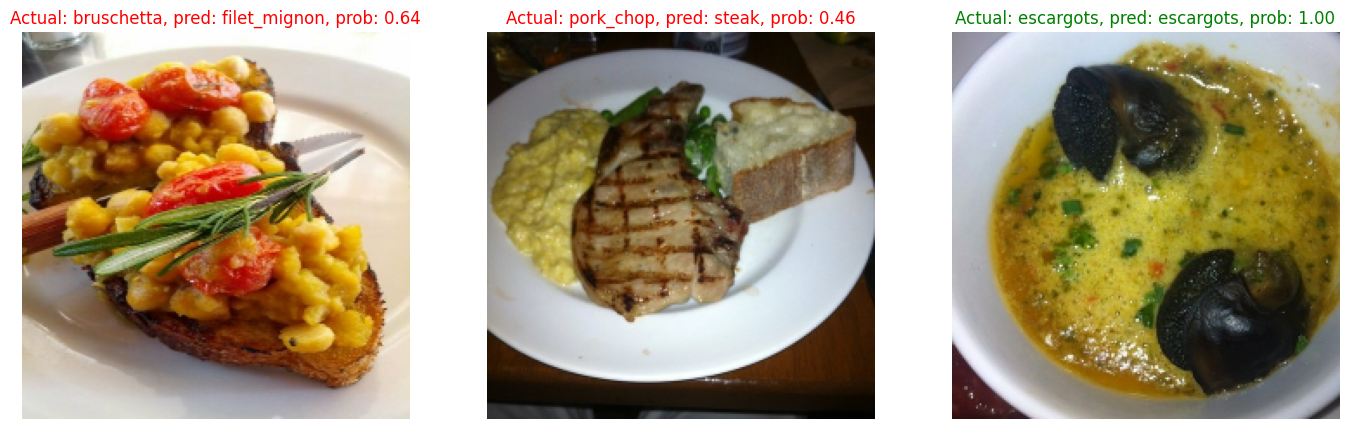

In [49]:
import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize = (17, 10))

for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + '/' + class_name))
  filepath = test_dir + class_name + '/' + filename

  img = load_and_pred_image(filepath , scale = False)
  pred_prob = model.predict(tf.expand_dims(img, axis = 0))
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)

  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = 'r'

  plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c = title_color)
  plt.axis(False)

# finding the most wrong predictions

It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These most wrong predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:

1. Get all of the image file paths in the test dataset using the `list_files()` method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
- Note: We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [50]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [1]:
pred_probs = []
for img in filepaths:
  result = model.predict(argmax(load_and_pred_image(img, scale = False), axis =0))
  break

NameError: name 'filepaths' is not defined

In [51]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()


,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,55,12,0.534681,hot_dog,cannoli
1,b'101_food_classes_10_percent/test/apple_pie/1...,82,83,0.937108,ravioli,red_velvet_cake
2,b'101_food_classes_10_percent/test/apple_pie/1...,96,28,0.355535,tacos,croque_madame
3,b'101_food_classes_10_percent/test/apple_pie/1...,75,88,0.999995,pho,seaweed_salad
4,b'101_food_classes_10_percent/test/apple_pie/1...,42,33,0.812639,french_toast,edamame


In [52]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()


,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,55,12,0.534681,hot_dog,cannoli,False
1,b'101_food_classes_10_percent/test/apple_pie/1...,82,83,0.937108,ravioli,red_velvet_cake,False
2,b'101_food_classes_10_percent/test/apple_pie/1...,96,28,0.355535,tacos,croque_madame,False
3,b'101_food_classes_10_percent/test/apple_pie/1...,75,88,0.999995,pho,seaweed_salad,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,42,33,0.812639,french_toast,edamame,False
